# Getting Started

In this tutorial, you'll learn the basics of using the `py21cmsense` library. See the [README](https://github.com/steven-murray/21cmSense) or the [CLI-tutorial](https://21cmsense.readthedocs.io/en/latest/tutorials/cli_tutorial.html) for information on the CLI interface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from py21cmsense import GaussianBeam, Observatory, Observation, PowerSpectrum, hera

## A Really Quick Demo

Let's first just show how to go from nothing to a power spectrum sensitivity in a few lines. You'll need the four main components of the sensitivity -- a `PrimaryBeam` (in this case, the default `GaussianBeam`), an `Observatory`, an `Observation` and a `Sensitivity` (in this case, a `PowerSpectrum` one).

We can literally construct the whole thing at once:

In [2]:
sensitivity = PowerSpectrum(
    observation = Observation(
        observatory = Observatory(
            antpos = hera(hex_num=7, l=14, dl=12.12),
            beam = GaussianBeam(frequency=135.0, dish_size=14),
            latitude=38*np.pi/180.0
        )
    )
)

**Note that this uses a default power spectrum from 21cmFAST defined at $z=9.5$. It is up to you to use a different power spectrum if your observation redshift is different.**

If all we care about is the 1D power spectrum sensitivity (including thermal noise and sample variance):

In [3]:
power_std = sensitivity.calculate_sensitivity_1d()

calculating 2D sensitivity:   0%|          | 0/216 [00:00<?, ?uv-bins/s]/home/steven/miniconda3/envs/21cmSense/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
averaging to 1D: 100%|██████████| 66/66 [00:01<00:00, 44.13kpar bins/s]
/home/steven/miniconda3/envs/21cmSense/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


We can plot the sensitivity:

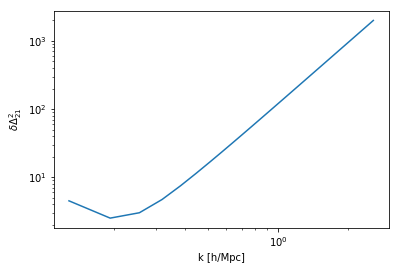

In [4]:
plt.plot(sensitivity.k1d, power_std)
plt.xlabel("k [h/Mpc]")
plt.ylabel(r'$\delta \Delta^2_{21}$')
plt.yscale('log')
plt.xscale('log')

We could also have gotten the thermal-only and sample-only variance:

In [5]:
power_std_thermal = sensitivity.calculate_sensitivity_1d(thermal=True, sample=False)
power_std_sample = sensitivity.calculate_sensitivity_1d(thermal=False, sample=True)

averaging to 1D: 100%|██████████| 66/66 [00:01<00:00, 37.54kpar bins/s]


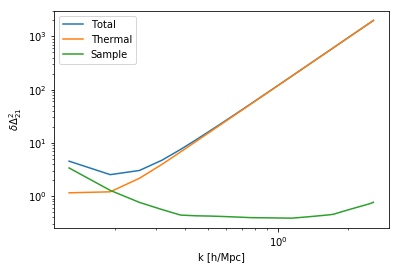

In [6]:
plt.plot(sensitivity.k1d, power_std, label='Total')
plt.plot(sensitivity.k1d, power_std_thermal, label='Thermal')
plt.plot(sensitivity.k1d, power_std_sample, label='Sample')

plt.xlabel("k [h/Mpc]")
plt.ylabel(r'$\delta \Delta^2_{21}$')
plt.yscale('log')
plt.xscale('log')
plt.legend();

## The Beam Object

Let's go a bit more carefully and slowly through each of the components of the calculation. First we constructed a beam object. This can be directly accessed from our `sensitivity`:

In [7]:
beam = sensitivity.observation.observatory.beam

The beam houses attributes concerning the width and frequency-dependence of the beam. In practice, for the purpose of `21cmSense`, it defines both the duration of an LST-bin (i.e. a set of times that for a given baseline can be coherently averaged) and the width of a UV cell (in the default settings, all baselines that fall into a given UV cell in a given LST bin are coherently averaged). It also defines the extent of the "wedge". 

Note that beam objects (and, indeed, all objects in `21cmSense`) give all their outputs with `astropy`-based units. Here's some examples:

In [8]:
beam.fwhm()

<Quantity 0.16774102 rad>

In [9]:
beam.uv_resolution

6.304361399245074

In [10]:
beam.b_eff()

<Quantity 0.06358973 rad2>

Note that `PrimaryBeam` objects have methods that take a single parameter -- frequency. However, the _fiducial_ frequency of the observation is passed to the constructor itself, and by default this is used:

In [11]:
beam.frequency

<Quantity 135. MHz>

In [12]:
beam.b_eff(160)/beam.b_eff()

<Quantity 0.71191406>

## The `Observatory`

Next in the hierarchy of objects is the `Observatory`, which defines the attributes of the observatory itself. There are several options that can be given to its constructor, but it _requires_ an array of antenna positions and a beam object (assumed to be the same for all antennas). You can view its documentation either with the `help` function, or at [the online docs](https://21cmsense.readthedocs.io/en/latest/reference/_autosummary/observatory/py21cmsense.observatory.Observatory.html#py21cmsense.observatory.Observatory).

It also has some handy methods:

In [13]:
observatory = sensitivity.observation.observatory

We can easily make a plot of the baseline positions:

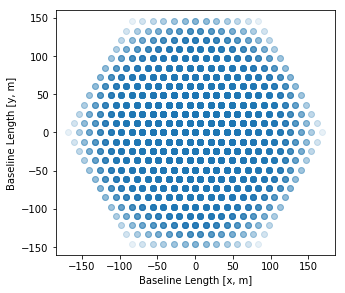

In [14]:
plt.figure(figsize=(5,4.5))
plt.scatter(observatory.baselines_metres[:,:, 0], observatory.baselines_metres[:,:,1], alpha=0.1)
plt.xlabel("Baseline Length [x, m]")
plt.ylabel("Baseline Length [y, m]");

Or we can make a histogram of the baseline lengths (in wavelengths):

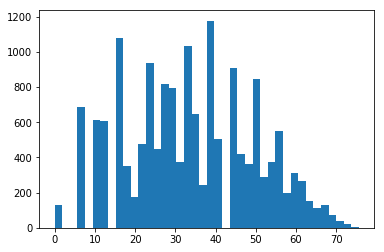

In [15]:
plt.hist(observatory.baseline_lengths.flatten(), bins=40);

The duration of an LST bin is also encoded in the observatory:

In [16]:
observatory.observation_duration.to("min")

<Quantity 38.44340957 min>

The `Observatory` is in charge of the work of finding redundant baseline groups, as well as gridding the baselines (though these methods are _called_ from the `Observation` itself):

In [17]:
red_bl = observatory.get_redundant_baselines()

finding redundancies: 100%|██████████| 126/126 [00:00<00:00, 474.34ants/s]


The output of this method is a little obfuscated, but it can be converted to something more easy to deal with:

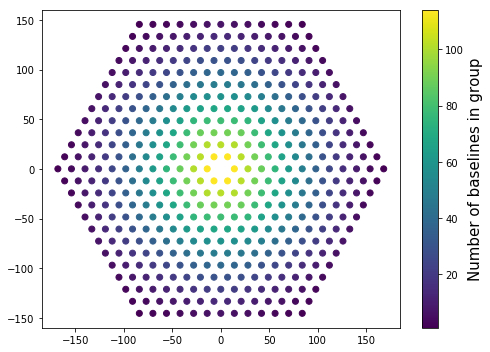

In [18]:
baseline_group_coords = observatory.baseline_coords_from_groups(red_bl)
baseline_group_counts = observatory.baseline_weights_from_groups(red_bl)


plt.figure(figsize=(7,5))
plt.scatter(baseline_group_coords[:,0], baseline_group_coords[:,1], c=baseline_group_counts)
cbar = plt.colorbar();
cbar.set_label("Number of baselines in group", fontsize=15)
plt.tight_layout();

To grid the baselines, with rotation synthesis:

In [19]:
coherent_grid = observatory.grid_baselines_coherent(
    baselines=baseline_group_coords,
    weights=baseline_group_counts
)

gridding baselines: 100%|██████████| 468/468 [00:00<00:00, 11325.10baselines/s]


And we can view this grid:

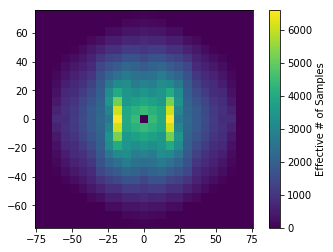

In [20]:
plt.imshow(coherent_grid, extent=(observatory.ugrid().min(), observatory.ugrid().max())*2)
cbar = plt.colorbar()
cbar.set_label("Effective # of Samples")

### The `Observation`

The `Observation` object has many more user-fed parameters -- again, see them by using `help(Observation)`, or by reading the [online docs](https://21cmsense.readthedocs.io/en/latest/reference/_autosummary/observation/py21cmsense.observation.Observation.html#py21cmsense.observation.Observation).
Primarily, its job is to use these parameters to supply the `Observatory` methods with the parameters they need to derive their results.

In [21]:
observation = sensitivity.observation

For example, the baseline groups derived in the previous section show up as an _attribute_ of the `Observation`:

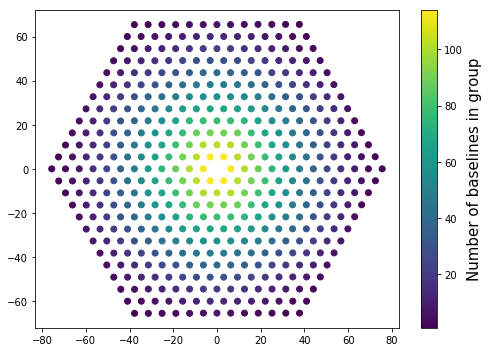

In [22]:
plt.figure(figsize=(7,5))
x = [bl_group[0] for bl_group in observation.baseline_groups]
y = [bl_group[1] for bl_group in observation.baseline_groups]
c = [len(bls) for bls in observation.baseline_groups.values()]

plt.scatter(x, y, c=c)
cbar = plt.colorbar();
cbar.set_label("Number of baselines in group", fontsize=15)
plt.tight_layout();

We can also get the total effective integration time spent in each UV cell (adjusting for coherent and incoherent averaging and all baselines):

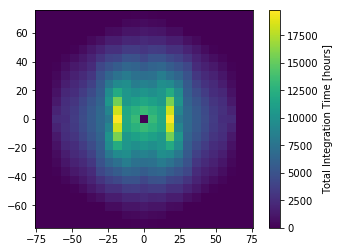

In [23]:
plt.imshow(observation.total_integration_time.to("hour").value, extent=(observation.ugrid.min(), observation.ugrid.max())*2)
cbar = plt.colorbar()
cbar.set_label("Total Integration Time [hours]")

One nifty feature is that you can clone any of these objects, and replace certain attributes. So we can do:

In [24]:
observation_2 = observation.clone(coherent=False)

gridding baselines: 100%|██████████| 468/468 [00:00<00:00, 13238.29baselines/s]


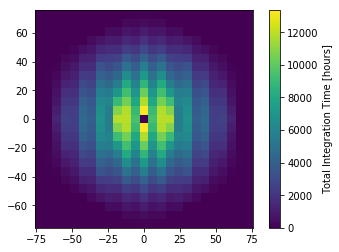

In [25]:
plt.imshow(observation_2.total_integration_time.to("hour").value, 
           extent=(observation_2.ugrid.min(), observation_2.ugrid.max())*2)
cbar = plt.colorbar()
cbar.set_label("Total Integration Time [hours]")

Notice the reduction in effective integration time due to the assumption that different baseline groups cannot ever be averaged coherently.

Note also that these objects can be directly compared:

In [26]:
observation == observation_2

False

## The `Sensitivity`

The design of `21cmSense` is such that one might define sensitivity calculations for arbitrary statistical measurements from an interferometer. The default one that is implemented is the power spectrum (both 1D and 2D cylindrical).

We have already shown some methods of the `PowerSpectrum` `Sensitivity`. It also has some helpful methods to calculate horizon lines etc. Let's see what the 2D sensitivity looks like:

In [27]:
sense2d = sensitivity.calculate_sensitivity_2d()

The output here is a little strange -- a dict of arrays. It can be used to make a 2D plot though:

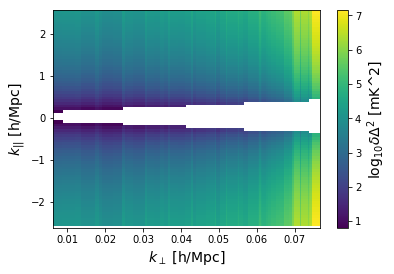

In [32]:
sensitivity.plot_sense_2d(sense2d)